In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
# ------------------------------------------------------------
# Instalación y carga de librerías necesarias
# ------------------------------------------------------------

# Lista de paquetes requeridos
required_packages <- c("ggplot2", "forecast", "tseries", "readr", "dplyr", "uroot", "FinTS", "uroot", "astsa")

# Función para instalar paquetes que no estén ya instalados
install_if_missing <- function(packages) {
  new_packages <- packages[!(packages %in% installed.packages()[,"Package"])]
  if(length(new_packages)) install.packages(new_packages)
}

# Instalar paquetes faltantes
install_if_missing(required_packages)

# Cargar las librerías
library(ggplot2)
library(forecast)
library(tseries)
library(readr)
library(dplyr)
library(uroot)
library(FinTS)
library(astsa)



  method            from
  as.zoo.data.frame zoo 

    ‘tseries’ version: 0.10-57

    ‘tseries’ is a package for time series analysis and computational
    finance.

    See ‘library(help="tseries")’ for details.


Attaching package: ‘dplyr’



    filter, lag



    intersect, setdiff, setequal, union



Attaching package: ‘zoo’



    as.Date, as.Date.numeric


Attaching package: ‘FinTS’



    Acf


Attaching package: ‘astsa’



    gas




In [ ]:
%%R
# ---------------------------------
# Carga de datos
# ---------------------------------

# Cargar los datos
data <- read.table("qc00000320.txt", header = FALSE, sep = " ")

# Exploración inicial de los datos
str(data)
head(data)
summary(data)


'data.frame':	29524 obs. of  6 variables:
 $ V1: int  1935 1935 1935 1935 1935 1935 1935 1935 1935 1935 ...
 $ V2: int  1 1 1 1 1 1 1 1 1 1 ...
 $ V3: int  1 2 3 4 5 6 7 8 9 10 ...
 $ V4: num  0 0 0 0 0 0 0 0 0 0 ...
 $ V5: num  -99.9 -99.9 30.5 31.5 31 29.6 29.2 30.8 31.1 31 ...
 $ V6: num  18.1 18 19.3 18.3 16 17 14.8 17.8 17.5 18.4 ...
       V1             V2               V3              V4         
 Min.   :1935   Min.   : 1.000   Min.   : 1.00   Min.   :-99.900  
 1st Qu.:1955   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.:  0.000  
 Median :1975   Median : 7.000   Median :16.00   Median :  0.000  
 Mean   :1975   Mean   : 6.513   Mean   :15.73   Mean   : -7.006  
 3rd Qu.:1995   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:  0.000  
 Max.   :2015   Max.   :12.000   Max.   :31.00   Max.   : 78.200  
       V5              V6         
 Min.   :-99.9   Min.   :-99.900  
 1st Qu.: 26.8   1st Qu.: 13.000  
 Median : 29.2   Median : 15.500  
 Mean   : 21.8   Mean   :  9.204  
 3rd Qu.: 32.0 

In [ ]:
%%R
# ---------------------------------
# Preparación y limpieza de datos
# ---------------------------------

# Asignar nombres a las columnas
colnames(data) <- c("Año", "Mes", "Día", "Precipitación", "Temp_Max", "Temp_Min")

# Reemplazar valores -99.9 o -99.90 con NA para indicar datos faltantes
data[data == -99.9 | data == -99.90] <- NA

# Convertir las columnas numéricas apropiadamente
numeric_cols <- c("Precipitación", "Temp_Max", "Temp_Min")
data[numeric_cols] <- lapply(data[numeric_cols], as.numeric)

# Calcular la temperatura promedio diaria
data$Temp_Promedio <- rowMeans(data[, c("Temp_Max", "Temp_Min")], na.rm = TRUE)

# Crear una columna de fecha
data$Fecha <- as.Date(with(data, paste(Año, Mes, Día, sep = "-")), "%Y-%m-%d")

# Ordenar los datos por fecha
data <- data[order(data$Fecha), ]

# Eliminar filas con NA en la temperatura promedio o en la fecha
data <- data[complete.cases(data$Temp_Promedio, data$Fecha), ]

# Verificar los datos después de la limpieza
str(data)
head(data)
summary(data$Temp_Promedio)


'data.frame':	28294 obs. of  8 variables:
 $ Año          : int  1935 1935 1935 1935 1935 1935 1935 1935 1935 1935 ...
 $ Mes          : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Día          : int  1 2 3 4 5 6 7 8 9 10 ...
 $ Precipitación: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Temp_Max     : num  NA NA 30.5 31.5 31 29.6 29.2 30.8 31.1 31 ...
 $ Temp_Min     : num  18.1 18 19.3 18.3 16 17 14.8 17.8 17.5 18.4 ...
 $ Temp_Promedio: num  18.1 18 24.9 24.9 23.5 23.3 22 24.3 24.3 24.7 ...
 $ Fecha        : Date, format: "1935-01-01" "1935-01-02" ...
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9.80   20.40   22.60   22.75   25.25   35.00 


In [ ]:
%%R
# ---------------------------------
# Análisis estadístico descriptivo
# ---------------------------------

# Estadísticas descriptivas de la temperatura promedio
mean_temp <- mean(data$Temp_Promedio)
median_temp <- median(data$Temp_Promedio)
sd_temp <- sd(data$Temp_Promedio)
var_temp <- var(data$Temp_Promedio)
min_temp <- min(data$Temp_Promedio)
max_temp <- max(data$Temp_Promedio)
quantiles_temp <- quantile(data$Temp_Promedio)

# Mostrar las estadísticas
cat("Temperatura Promedio:\n")
cat("Media:", mean_temp, "\n")
cat("Mediana:", median_temp, "\n")
cat("Desviación Estándar:", sd_temp, "\n")
cat("Varianza:", var_temp, "\n")
cat("Mínimo:", min_temp, "\n")
cat("Máximo:", max_temp, "\n")
cat("Cuantiles:\n")
print(quantiles_temp)


Temperatura Promedio:
Media: 22.7504 
Mediana: 22.6 
Desviación Estándar: 3.218126 
Varianza: 10.35633 
Mínimo: 9.8 
Máximo: 35 
Cuantiles:
   0%   25%   50%   75%  100% 
 9.80 20.40 22.60 25.25 35.00 


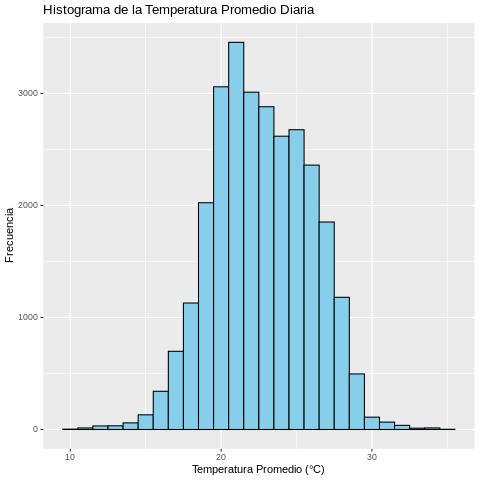

In [ ]:
%%R
# ---------------------------------
# Visualización de datos
# ---------------------------------

# Histograma de la temperatura promedio
ggplot(data, aes(x = Temp_Promedio)) +
  geom_histogram(binwidth = 1, fill = "skyblue", color = "black") +
  labs(title = "Histograma de la Temperatura Promedio Diaria",
       x = "Temperatura Promedio (°C)",
       y = "Frecuencia")

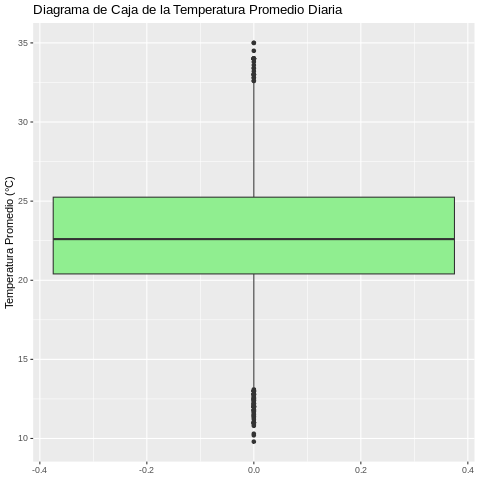

In [ ]:
%%R
# ---------------------------------
# Visualización de datos
# ---------------------------------

# Diagrama de caja (boxplot) de la temperatura promedio
ggplot(data, aes(y = Temp_Promedio)) +
  geom_boxplot(fill = "lightgreen") +
  labs(title = "Diagrama de Caja de la Temperatura Promedio Diaria",
       y = "Temperatura Promedio (°C)")


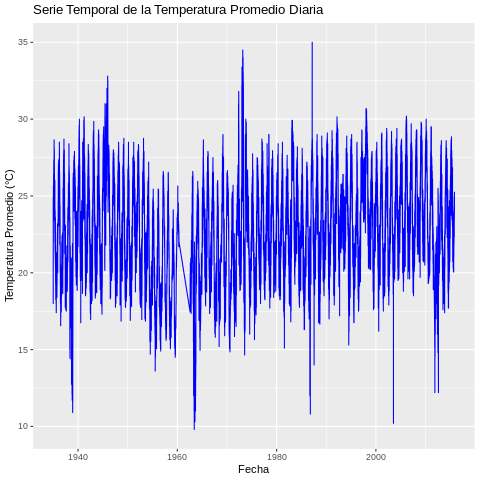

In [ ]:
%%R
# ---------------------------------
# Visualización de datos
# ---------------------------------

# Serie temporal de la temperatura promedio
ggplot(data, aes(x = Fecha, y = Temp_Promedio)) +
  geom_line(color = "blue") +
  labs(title = "Serie Temporal de la Temperatura Promedio Diaria",
       x = "Fecha",
       y = "Temperatura Promedio (°C)")


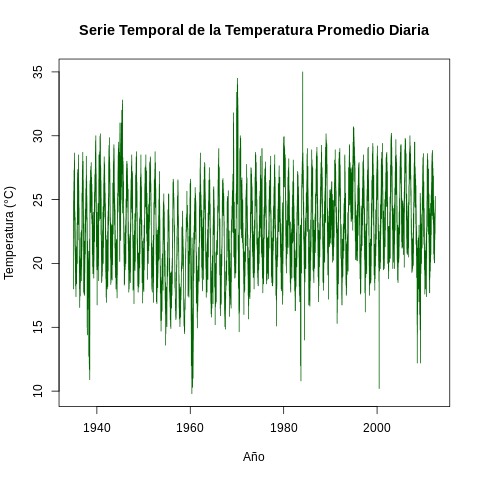

In [ ]:
%%R
# ---------------------------------
# Creación de la serie temporal
# ---------------------------------

# Crear la serie temporal de la temperatura promedio
# Como los datos son diarios, la frecuencia es 365 (o 366 en años bisiestos)
# Para una mejor aproximación, podríamos usar frecuencia 365.25
ts_temp <- ts(data$Temp_Promedio, start = c(min(data$Año), min(data$Mes)), frequency = 365.25)

# Visualización inicial de la serie temporal
plot(ts_temp, main = "Serie Temporal de la Temperatura Promedio Diaria",
     ylab = "Temperatura (°C)", xlab = "Año", col = "darkgreen")


In [ ]:
%%R
# ------------------------------------------------------------
# Prueba de estacionariedad
# ------------------------------------------------------------

# Prueba de Dickey-Fuller Aumentada (ADF)
adf_test <- adf.test(ts_temp, alternative = "stationary")

# Mostrar los resultados de la prueba ADF
print(adf_test)

# Interpretación
if(adf_test$p.value < 0.05) {
  cat("El p-valor es", adf_test$p.value, "< 0.05. Rechazamos la hipótesis nula. La serie es estacionaria.\n")
} else {
  cat("El p-valor es", adf_test$p.value, ">= 0.05. No podemos rechazar la hipótesis nula. La serie no es estacionaria.\n")
}



	Augmented Dickey-Fuller Test

data:  ts_temp
Dickey-Fuller = -10.597, Lag order = 30, p-value = 0.01
alternative hypothesis: stationary

El p-valor es 0.01 < 0.05. Rechazamos la hipótesis nula. La serie es estacionaria.


In [ ]:
%%R
# ---------------------------------
# Transformación de la serie (diferenciación) si es necesario
# ---------------------------------

# Si la serie no es estacionaria, aplicar diferenciación
if(adf_test$p.value > 0.05) {
  ts_temp_diff <- diff(ts_temp, differences = 1)
  # Verificar estacionariedad nuevamente
  adf_test_diff <- adf.test(ts_temp_diff, alternative = "stationary")
  print(adf_test_diff)

  # Usar la serie diferenciada para el modelado
  ts_modeling <- ts_temp_diff
} else {
  # Usar la serie original
  ts_modeling <- ts_temp
}

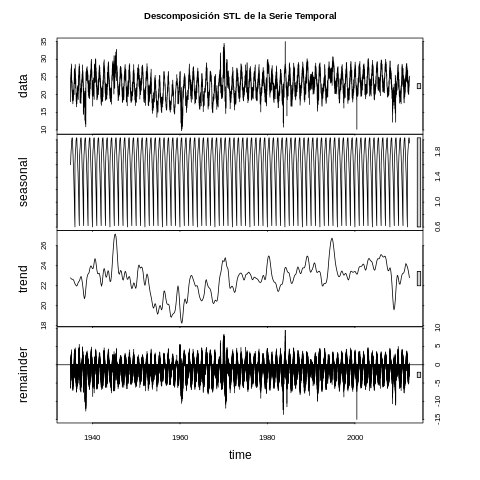

In [ ]:
%%R
# ---------------------------------
# Descomposición de la serie temporal
# ---------------------------------

# Descomposición usando STL (Seasonal and Trend decomposition using Loess)
ts_decomp <- stl(ts_modeling, s.window = "periodic")

# Visualización de la descomposición
plot(ts_decomp, main = "Descomposición STL de la Serie Temporal")

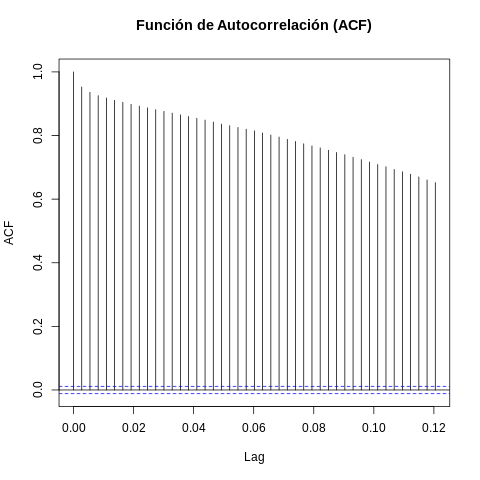

In [ ]:
%%R
# ---------------------------------
# Análisis de autocorrelación
# ---------------------------------

# Gráfico de ACF
acf(ts_modeling, main = "Función de Autocorrelación (ACF)")

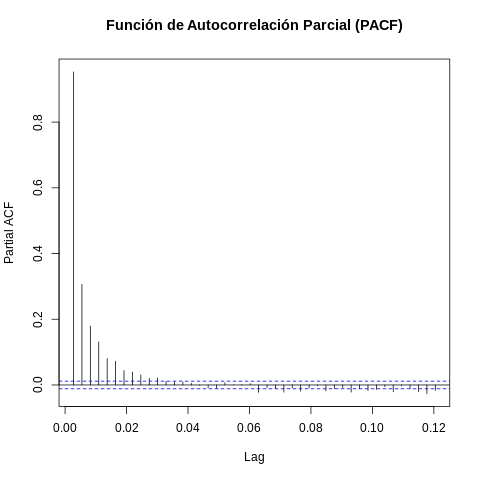

In [ ]:
%%R
# ---------------------------------
# Análisis de autocorrelación
# ---------------------------------

# Gráfico de PACF
pacf(ts_modeling, main = "Función de Autocorrelación Parcial (PACF)")


	OCSB test

data:  ts_modeling

Test statistic: -163.0638, 5% critical value: -1.6662
alternative hypothesis: stationary

Lag order 0 was selected using fixed

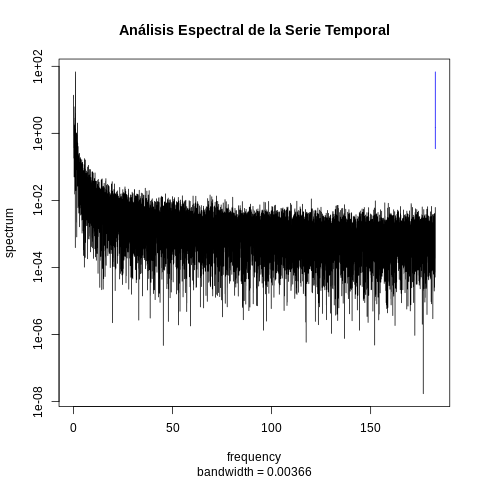

In [ ]:
%%R
# ------------------------------------------------------------
# Análisis de estacionalidad
# ------------------------------------------------------------

# Análisis espectral para identificar frecuencias dominantes
spectrum(ts_modeling, main = "Análisis Espectral de la Serie Temporal")

# Prueba de estacionalidad OCSB
ocsb_test <- ocsb.test(ts_modeling)
print(ocsb_test)


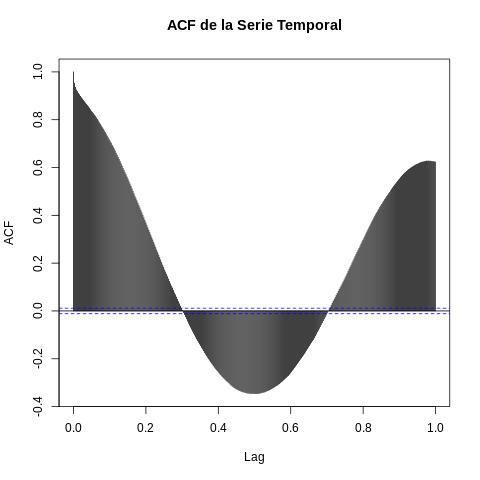

In [ ]:
%%R
# ------------------------------------------------------------
# Gráficos ACF y PACF en rezagos estacionales
# ------------------------------------------------------------

# Definir el máximo de rezagos como un múltiplo del período estacional
lag_max <- 365  # Un año para datos diarios

# Gráfico de ACF en rezagos estacionales
acf(ts_modeling, lag.max = lag_max, main = "ACF de la Serie Temporal")

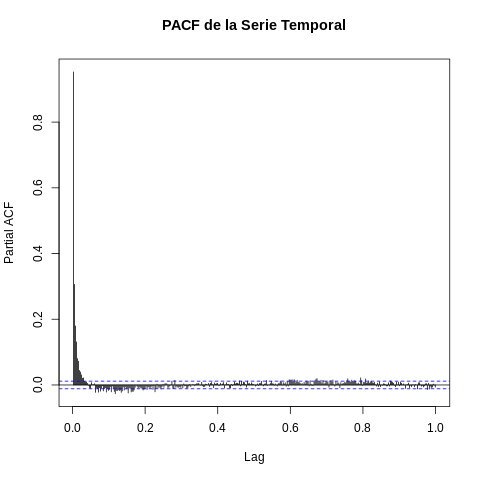

In [ ]:
%%R
# ------------------------------------------------------------
# Gráficos ACF y PACF en rezagos estacionales
# ------------------------------------------------------------

# Definir el máximo de rezagos como un múltiplo del período estacional
lag_max <- 365  # Un año para datos diarios

# Gráfico de PACF en rezagos estacionales
pacf(ts_modeling, lag.max = lag_max, main = "PACF de la Serie Temporal")

In [ ]:
%%R
# Ajustar el modelo ARIMA(5,0,1)(0,1,0)[365]
model_arima <- Arima(ts_modeling,
  order = c(5, 0, 1),          # Órdenes no estacionales (p, d, q)
  seasonal = list(order = c(0, 1, 0), period = 365))  # Órdenes estacionales (P, D, Q) y período

# Resumen del modelo ajustado
summary(model_arima)

Series: ts_modeling 
ARIMA(5,0,1)(0,1,0)[365] 

Coefficients:
         ar1      ar2      ar3     ar4      ar5      ma1
      1.4087  -0.3274  -0.0522  0.0049  -0.0390  -0.8745
s.e.  0.0134   0.0121   0.0106  0.0103   0.0073   0.0118

sigma^2 = 1.597:  log likelihood = -46165.62
AIC=92345.25   AICc=92345.25   BIC=92402.91

Training set error measures:
                       ME     RMSE       MAE        MPE     MAPE      MASE
Training set 0.0008022243 1.255459 0.9285058 -0.1594391 4.183488 0.4563393
                      ACF1
Training set -0.0002982221



	Ljung-Box test

data:  Residuals from ARIMA(5,0,1)(0,1,0)[365]
Q* = 8184.2, df = 724.5, p-value < 2.2e-16

Model df: 6.   Total lags used: 730.5


	Box-Ljung test

data:  residuals(model_arima)
X-squared = 24.057, df = 14, p-value = 0.04511



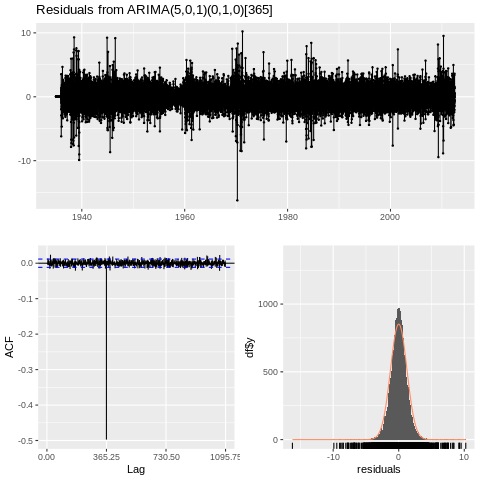

In [19]:
%%R
# ------------------------------------------------------------
# Diagnóstico del modelo SARIMA
# ------------------------------------------------------------

# Verificación de los residuos
checkresiduals(model_arima)

# Prueba de Ljung-Box en residuos estacionales
lag_max_resid <- 20  # Número de rezagos para la prueba
ljung_box <- Box.test(residuals(model_arima), lag = lag_max_resid, type = "Ljung-Box", fitdf = length(model_arima$coef))
print(ljung_box)




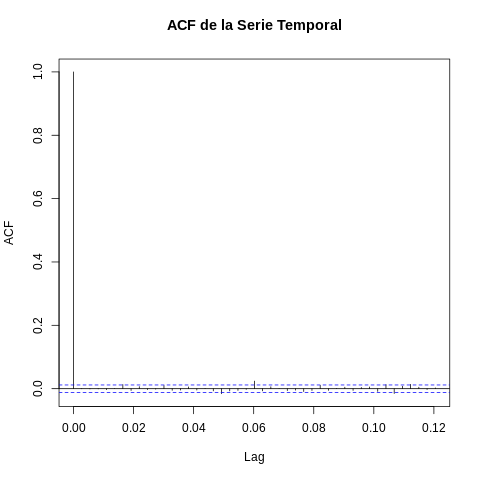

In [20]:
%%R
# Gráfico de ACF en rezagos estacionales
acf(residuals(model_arima), main = "ACF de la Serie Temporal")


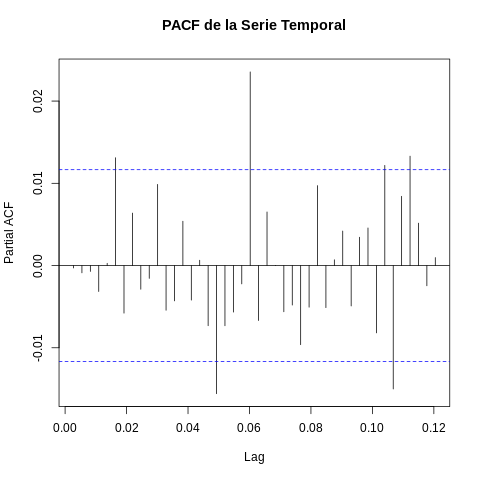

In [21]:
%%R
# Gráfico de PACF en rezagos estacionales
pacf(residuals(model_arima), main = "PACF de la Serie Temporal")

In [22]:
%%R
# Prueba de heterocedasticidad (ARCH test)
arch_test <- ArchTest(residuals(model_arima))
print(arch_test)

# Prueba de normalidad de Shapiro-Wilk
shapiro_test <- shapiro.test(residuals(model_arima))
print(shapiro_test)


	ARCH LM-test; Null hypothesis: no ARCH effects

data:  residuals(model_arima)
Chi-squared = 1243.8, df = 12, p-value < 2.2e-16



  sample size must be between 3 and 5000


 




Error in shapiro.test(residuals(model_arima)) : 
  sample size must be between 3 and 5000


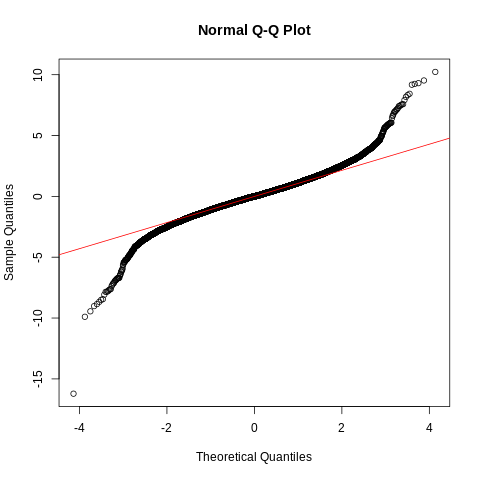

In [23]:
%%R
# QQ-Plot de los residuos
qqnorm(residuals(model_arima))
qqline(residuals(model_arima), col = "red")

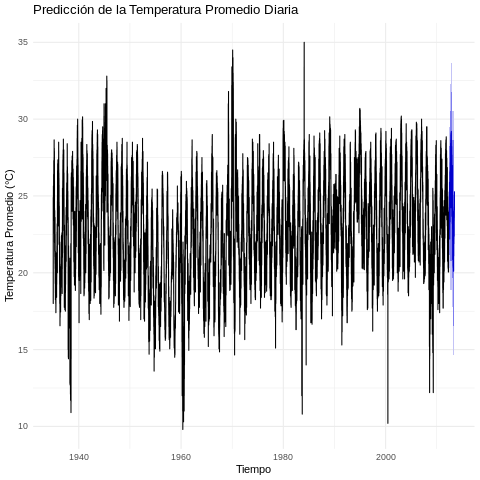

In [24]:
%%R
# ------------------------------------------------------------
# Predicción futura
# ------------------------------------------------------------

# Realizar predicciones futuras (por ejemplo, para los próximos 365 días)
forecast_future <- forecast(model_arima, h = 365)

# Visualización de las predicciones
autoplot(forecast_future) +
  labs(title = "Predicción de la Temperatura Promedio Diaria",
       x = "Tiempo",
       y = "Temperatura Promedio (°C)") +
  theme_minimal()